In [9]:
#input convolutional network accepts 2-dim and 3-dim -
#kernel size - 3x3
#sliding window principle 
#polling principle - e.g  max pooling  
#multiple layers - 3-4-5. 
#cats vs dogs 

#cats vs dogs microsoft datasets
#https://www.microsoft.com/en-us/download/details.aspx?id=54765

import os
import cv2
import numpy as np
from tqdm import tqdm

#flag for preprocessing / alternative seperate
REBUILD_DATA = True



In [10]:


class DogsVSCats():
    IMG_SIZE=50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1} # we should one hot encode this
    training_data = []
    catcount = 0
    dogcount = 0
    
    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            
            #list over directory
            for f in tqdm(os.listdir(label)):
                try:
                    path = os.path.join(label, f)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                        
                    if label == self.CATS:
                        self.catcount +=1
                    elif label == self.DOGS:
                        self.dogcount +=1
                except Exception as e:
                    #print(e)
                    pass
                
        
        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats:", self.catcount)
        print("Dogs:",self.dogcount)


In [11]:
if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()




  0%|          | 0/12501 [00:00<?, ?it/s]

PetImages/Cat


  0%|          | 43/12501 [00:00<00:29, 428.54it/s]

PetImages/Dog


100%|██████████| 12501/12501 [00:26<00:00, 467.48it/s]


Cats: 12476
Dogs: 12470


In [12]:
REBUILD_DATA = False

training_data = np.load("training_data.npy", allow_pickle=True)

In [13]:
print(len(training_data))

24946


In [33]:
print(training_data[0])

[array([[ 73,  74,  73, ..., 172, 173, 172],
       [ 73,  73,  74, ..., 171, 172, 168],
       [ 73,  72,  73, ..., 172, 173, 172],
       ...,
       [ 70,  78,  75, ..., 164, 171, 171],
       [ 68,  83,  88, ..., 167, 166, 168],
       [ 79,  65,  78, ..., 168, 167, 171]], dtype=uint8)
 array([1., 0.])]


(24946, 2)
[1. 0.]


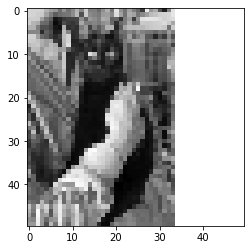

In [14]:
import matplotlib.pyplot as plt

print(training_data.shape)
plt.imshow(training_data[2][0], cmap="gray")
print(training_data[2][1])

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net (nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,5)
        self.conv2 = nn.Conv2d(32,64,5)
        self.conv3 = nn.Conv2d(64,128,5)
        
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear,512)
        self.fc2 = nn.Linear(512,2)
        
    def convs(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2)) 
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2)) 
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2)) 
        
      #  print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
        
        
     

In [28]:
net = Net()

In [29]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr =0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
#print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))



22452
2494


In [30]:
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        #print(i, i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs,batch_y)
        loss.backward()
        optimizer.step()
        
print(loss)


100%|██████████| 225/225 [01:37<00:00,  2.32it/s]

tensor(0.2453, grad_fn=<MseLossBackward>)


In [36]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net (test_X[i].view(-1,1,50,50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct +=1
        total +=1
        
print(correct)
print(total)
print("accuracy", round(correct/total,3))
        
        


100%|██████████| 2494/2494 [00:05<00:00, 435.64it/s]

1669
2494
accuracy 0.669
